In [1]:
from firedrake import *

In [2]:
mesh = UnitSquareMesh(10, 10)
R = 100
mesh.coordinates.dat.data[:] *= R

x, y = SpatialCoordinate(mesh)
Q = FunctionSpace(mesh, "CG", 2)
V = VectorFunctionSpace(mesh, "CG", 2)
q = firedrake.TestFunction(Q)

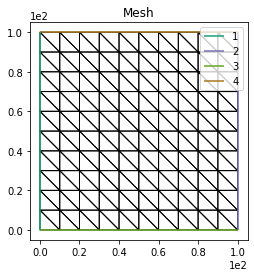

In [3]:
import icepack.plot
fig, axes = icepack.plot.subplots()
icepack.plot.triplot(mesh, axes=axes)
axes.set_title('Mesh');
axes.legend();

In [4]:
# Set the velocity
x_velocity = Constant(0)
y_velocity = Constant(-.5)
u = interpolate(as_vector([x_velocity,y_velocity]),V)

# Set the initial age field and age function
a0 = interpolate(R-y,Q)
a_prior = a0.copy()
a = Function(Q)

# Set the time step and source (which eaquals the time step)
dt = .1
s = interpolate(Constant(dt),Q)

In [5]:
# Use a Crank-Nicholson time discretization of the age evolution equation
J = (((a-a_prior)/s + .5*inner(u,grad(a-a_prior))) - (s - inner(u,grad(a_prior)))) * q * dx

# Do we want a boundary condition that forces the age to be zero at the surface?
#bc = DirichletBC(V, 0., [4])

In [6]:
# Loop through time steps
import numpy as np
ntsteps = 1 # There's a convergence error if I go above one time step
for t in range(ntsteps):
    solve(J == 0, a)#, bcs=[bc])
    a_prior = a.copy()
    a = Function(Q)

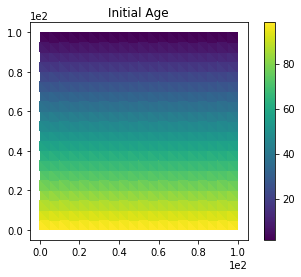

In [7]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tripcolor(interpolate(a0,Q), axes=axes)
fig.colorbar(contours)
axes.set_title('Initial Age');

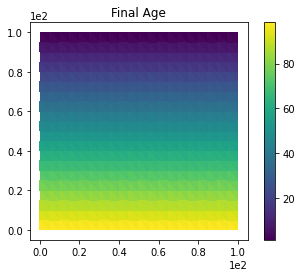

In [8]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tripcolor(interpolate(a_prior,Q), axes=axes)
fig.colorbar(contours)
axes.set_title('Final Age');

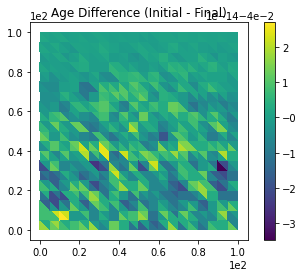

In [9]:
fig, axes = icepack.plot.subplots()
contours = icepack.plot.tripcolor(interpolate(a_prior-a0,Q), axes=axes)
fig.colorbar(contours)
axes.set_title('Age Difference (Initial - Final)');

In [10]:
# Implement a check with the known solution.